In [1]:
from numpy import pi, tan
from gpkit import Model, Variable, units
import gpkit
gpkit.settings['latex_modelname'] = False


class SolarHALE(Model):
    def setup(self):
        constraints = []
        
        # Steady level flight relations
        CD = Variable('C_D', '-', 'Drag coefficient')
        CL = Variable('C_L', '-', 'Lift coefficient')
        P_shaft = Variable('P_{shaft}', 'W', 'Shaft power')
        S = Variable('S', 'm^2', 'Wing reference area')
        V = Variable('V', 'm/s', 'Cruise velocity')
        W = Variable('W', 'lbf', 'Aircraft weight')
        
        eta_prop = Variable(r'\eta_{prop}', 0.7, '-', 'Propulsive efficiency')
        rho = Variable(r'\rho', 'kg/m^3')

        constraints.extend([P_shaft >= V*W*CD/CL/eta_prop,   # eta*P = D*V
                            W == 0.5*rho*V**2*CL*S])
        
        # Aerodynamics model
        Cd0 = Variable('C_{d0}', 0.01, '-', "non-wing drag coefficient")
        CLmax = Variable('C_{L-max}', 1.5, '-', 'maximum lift coefficient')
        e = Variable('e', 0.9, '-', "spanwise efficiency")
        A = Variable('A', 20, '-', "aspect ratio")
        b = Variable('b', 'ft', 'span')
        mu = Variable(r'\mu', 1.5e-5, 'N*s/m^2', "dynamic viscosity")
        Re = Variable("Re", '-', "Reynolds number")
        Cf = Variable("C_f", "-", "wing skin friction coefficient")
        Kwing = Variable("K_{wing}", 1.3, "-", "wing form factor")
        constraints.extend([CD >= Cd0 + Cf*Kwing + CL**2/(pi*e*A),
                            b**2 == S*A,
                            CL <= CLmax,
                            Re <= rho*V/mu*(S/A)**0.5,
                            Cf >= 0.074/Re**0.2])
        
        
        # Weight model
        W_batt = Variable('W_{batt}', 'lbf', 'Battery weight')
        W_airframe = Variable('W_{airframe}', 'lbf', 'Airframe weight')
        W_solar = Variable('W_{solar}', 'lbf', 'Solar panel weight')
        W_pay = Variable(r'W_{pay}', 4, 'lbf', 'Aircraft weight')
        
        E_batt = Variable('E_{batt}', 'J', 'Battery energy')
        rho_solar = Variable(r'\rho_{solar}', 1.2, 'kg/m^2', 'Solar cell area density')
        f_airframe = Variable('f_{airframe}', 0.25, '-', 'Airframe weight fraction')
        h_batt = Variable('h_{batt}', 0.8, 'MJ/kg', 'Battery energy density')
        g = Variable('g', 9.81, 'm/s^2', 'Gravitational acceleration')
        
        constraints.extend([W_airframe >= W*f_airframe,
                            W_batt >= E_batt/h_batt*g,
                            W_solar >= rho_solar*g*S,
                            W >= W_pay + W_solar + W_airframe + W_batt])
            
        # Power model
        PS_irr = Variable('(P/S)_{irr}', 1000*0.5, 'W/m^2', 'Average daytime solar irradiance')
        P_oper = Variable('P_{oper}', 'W', 'Aircraft operating power')
        P_charge = Variable('P_{charge}', 'W', 'Battery charging power')
        P_acc = Variable('P_{acc}', 10, 'W', 'Accessory power draw')
        eta_solar = Variable(r'\eta_{solar}', 0.2, '-', 'Solar cell efficiency')
        eta_charge = Variable(r'\eta_{charge}', 0.95, '-', 'Battery charging efficiency')
        eta_discharge = Variable(r'\eta_{discharge}', 0.95, '-', 'Battery discharging efficiency')
        t_day = Variable('t_{day}', 'hr', 'Daylight span')
        t_night = Variable('t_{night}', 12, 'hr', 'Night span')
        
        constraints.extend([PS_irr*eta_solar*S >= P_oper + P_charge,
                            P_oper >= P_shaft + P_acc,
                            P_charge >= E_batt/(t_day*eta_charge),
                            t_day + t_night <= 24*units.hr,
                            E_batt >= P_oper*t_night/eta_discharge])

        # Atmosphere model
        h = Variable("h", "ft", "Altitude")
        p_sl = Variable("p_{sl}", 101325, "Pa", "Pressure at sea level")
        T_sl = Variable("T_{sl}", 288.15, "K", "Temperature at sea level")
        L_atm = Variable("L_{atm}", 0.0065, "K/m", "Temperature lapse rate")
        T_atm = Variable("T_{atm}", "K", "air temperature")
        M_atm = Variable("M_{atm}", 0.0289644, "kg/mol", "Molar mass of dry air")
        R_atm = Variable("R_{atm}", 8.31447, "J/mol/K")
        TH = (g*M_atm/R_atm/L_atm).value.magnitude  # dimensionless
        constraints.extend([h <= 20000*units.m,  # Model valid to top of troposphere
                            T_sl >= T_atm + L_atm*h,     # Temp decreases w/ altitude
                            rho <= p_sl*T_atm**(TH-1)*M_atm/R_atm/(T_sl**TH)])  # http://en.wikipedia.org/wiki/Density_of_air#Altitude
        
        # station keeping requirement
        footprint = Variable("d_{footprint}", 200, 'km', "station keeping footprint diameter")
        lu = Variable(r"\theta{look-up}", 5, '-', "look up angle")
        R_earth = Variable("R_{earth}", 6371, "km", "Radius of earth")
        tan_lu = lu*pi/180. + (lu*pi/180.)**3/3.  # Taylor series expansion
        # approximate earth curvature penalty as distance^2/(2*Re)
        constraints.extend([h >= tan_lu*0.5*footprint + footprint**2/8./R_earth])

        objective = b
        
        return objective, constraints

m = SolarHALE()
res = m.solve("cvxopt")

Using solver 'cvxopt'
Solving for 19 variables.
Solving took 0.143 seconds.

Cost
----
 25.38 [ft] 

Free Variables
--------------
         C_D : 0.05865              Drag coefficient              
         C_L : 1.5                  Lift coefficient              
         C_f : 0.006814             wing skin friction coefficient
    E_{batt} : 6.457e+06  [J]       Battery energy                
  P_{charge} : 157.3      [W]       Battery charging power        
    P_{oper} : 142        [W]       Aircraft operating power      
   P_{shaft} : 132        [W]       Shaft power                   
          Re : 1.511e+05            Reynolds number               
           S : 2.993      [m**2]    Wing reference area           
     T_{atm} : 226.2      [K]       air temperature               
           V : 13.41      [m/s]     Cruise velocity               
           W : 39.63      [lbf]     Aircraft weight               
W_{airframe} : 9.907      [lbf]     Airframe weight              

In [2]:
import numpy as np
NX = 21
NY = 17
m.substitutions.update({"d_{footprint}": ('sweep', np.linspace(100, 300, NX)),
                        "h_{batt}": ('sweep', np.linspace(.8, 1.2, NY))})
sol = m.solve(verbosity=0)

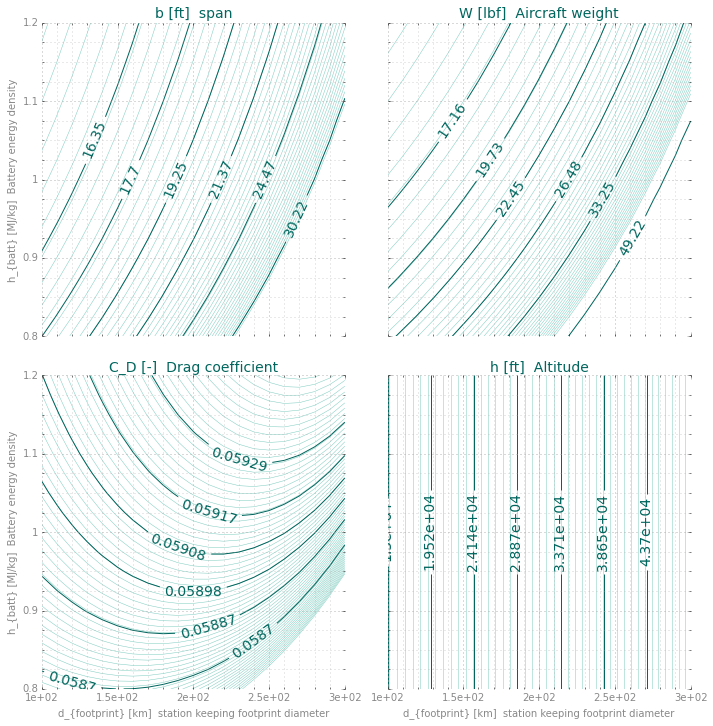

In [3]:
%matplotlib inline
from gpkit.interactive.plotting import contour_array
_ = contour_array(m, "d_{footprint}", "h_{batt}", ["b", "W", "C_D", "h"])